# Streaming

In [1]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph

In [2]:
# Helper
def visualize_graph(graph):
    from IPython.display import Image, display
    try:
        display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
    except Exception:
        # This requires some extra dependencies and is optional
        pass

In [3]:
def add(left, right):
    return left + right


class State(TypedDict):
    total: Annotated[int, add]

In [4]:
builder = StateGraph(State)
builder.add_node("add_one", lambda x: {"total": 1})
builder.add_node("double", lambda x: {"total": x["total"]})
builder.add_edge(START, "add_one")


def route(state: State) -> Literal["double", "__end__"]:
    if state["total"] < 6:
        return "double"
    return "__end__" # This is what END is


builder.add_conditional_edges("add_one", route)
builder.add_edge("double", "add_one")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

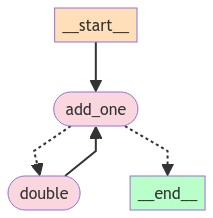

In [5]:
visualize_graph(graph)

In [6]:
thread_id = "some-thread"
config = {"configurable": {"thread_id": thread_id}}

graph.invoke({"total": 1}, config)

{'total': 11}

In [7]:
thread_id = "another-thread"
config = {"configurable": {"thread_id": thread_id}}

for step in graph.stream({"total": 1}, config):
    print(step)

{'add_one': {'total': 1}}
{'double': {'total': 2}}
{'add_one': {'total': 1}}
{'double': {'total': 5}}
{'add_one': {'total': 1}}


In [8]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'total': 11}, next=(), config={'configurable': {'thread_id': 'another-thread', 'thread_ts': '1ef2f8b0-7e1d-634c-8005-7eef273bc067'}}, metadata={'source': 'loop', 'step': 5, 'writes': {'add_one': {'total': 1}}}, created_at='2024-06-21T04:59:25.097439+00:00', parent_config=None)

In [9]:
snapshot.values

{'total': 11}

In [10]:
thread_id = "other-thread"
config = {"configurable": {"thread_id": thread_id}}

for step in graph.stream({"total": 1}, config, stream_mode="debug"):
    print(step["step"], step["type"], step["payload"].get("values"))

-1 checkpoint {'total': 0}
0 checkpoint {'total': 1}
1 task None
1 task_result None
1 checkpoint {'total': 2}
2 task None
2 task_result None
2 checkpoint {'total': 4}
3 task None
3 task_result None
3 checkpoint {'total': 5}
4 task None
4 task_result None
4 checkpoint {'total': 10}
5 task None
5 task_result None
5 checkpoint {'total': 11}


In [11]:
for step in graph.stream(
    {"total": -2, "turn": "First Turn"}, config, stream_mode="debug"
):
    print(step["step"], step["type"], step["payload"].get("values"))

6 checkpoint {'total': 11}
7 checkpoint {'total': 9}
8 task None
8 task_result None
8 checkpoint {'total': 10}
